# Lab 01: Urbana Weather

---
author: Tristan Yang
date: September 13, 2024
embed-resources: true
---

## Introduction

The purpose of this lab is to develop a predictive model that estimates the minimum daily temperature in Urbana, IL, based on historical weather data. This model will assist in determining the appropriate time to transition the Market at the Square, a local farmer’s market, from an outdoor to an indoor setting as temperatures drop in autumn. The market typically moves indoors when the weather becomes too cold, and accurate predictions are essential for providing advance notice to vendors, some of whom do not participate in the indoor market.

The data used for this task is obtained from the Open-Meteo API, which leverages reanalysis datasets compiled from various weather station, satellite, radar, and other observational sources. The historical dataset is segmented into different time frames for training, validation, and testing, covering the years 2016 through 2022, with the production dataset representing the year 2023. The goal is to create a model that accurately predicts the minimum daily temperature at two meters above ground, which is critical for making informed decisions regarding outdoor market operations.

## Methods

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from datetime import datetime
from joblib import dump



In [3]:
weather_train = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-train.csv",
    index_col = "date",
    parse_dates = True
    
)
weather_vtrain = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-vtrain.csv",
    index_col="date",
    parse_dates=True
)
weather_validation = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-validation.csv",
    index_col="date",
    parse_dates=True
)
weather_test = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-test.csv",
    index_col="date",
    parse_dates=True
)

### Data

In [4]:
# load data

weather_train


,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2016-01-01,-4.2715,2016,1,1,1
2016-01-02,-3.8715,2016,1,2,2
2016-01-03,-4.4715,2016,1,3,3
2016-01-04,-3.0215,2016,1,4,4
2016-01-05,-5.7715,2016,1,5,5
...,...,...,...,...,...
2021-12-27,6.9980,2021,12,27,361
2021-12-28,1.7980,2021,12,28,362
2021-12-29,2.1980,2021,12,29,363


In [5]:
weather_vtrain


,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2016-01-01,-4.2715,2016,1,1,1
2016-01-02,-3.8715,2016,1,2,2
2016-01-03,-4.4715,2016,1,3,3
2016-01-04,-3.0215,2016,1,4,4
2016-01-05,-5.7715,2016,1,5,5
...,...,...,...,...,...
2019-12-27,1.8480,2019,12,27,361
2019-12-28,0.2480,2019,12,28,362
2019-12-29,12.0480,2019,12,29,363


In [6]:
weather_validation


,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2020-01-01,-3.002,2020,1,1,1
2020-01-02,3.298,2020,1,2,2
2020-01-03,2.598,2020,1,3,3
2020-01-04,0.098,2020,1,4,4
2020-01-05,-4.552,2020,1,5,5
...,...,...,...,...,...
2021-12-27,6.998,2021,12,27,361
2021-12-28,1.798,2021,12,28,362
2021-12-29,2.198,2021,12,29,363


In [7]:
weather_test

,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2022-01-01,2.298,2022,1,1,1
2022-01-02,-5.402,2022,1,2,2
2022-01-03,-11.052,2022,1,3,3
2022-01-04,-5.602,2022,1,4,4
2022-01-05,-8.402,2022,1,5,5
...,...,...,...,...,...
2022-12-27,-11.052,2022,12,27,361
2022-12-28,-5.902,2022,12,28,362
2022-12-29,5.098,2022,12,29,363


In [8]:
day_of_year = weather_train.groupby('day_of_year')['temperature_2m_min'].agg(['count','mean','std'])
day_of_year

,count,mean,std
day_of_year,,,
1,6,-6.796917,8.740575
2,6,-4.313583,9.459488
3,6,-3.496917,6.141413
4,6,-7.413583,6.823789
5,6,-7.280250,6.451428
...,...,...,...
362,6,-3.096917,6.078772
363,6,-1.513583,8.043473
364,6,-4.646917,6.850892


In this section, we calculate and display summary statistics for the yearly and monthly weather data, such as the count, mean, and standard deviation. These statistics help in understanding the overall temperature trends and variations in Urbana, IL.

In [9]:
# summary statistics

# Group by year and calculate yearly statistics (count, mean, standard deviation)
yearly_stats = weather_train.groupby('year')['temperature_2m_min'].agg(['count','mean','std'])

# Group by month and calculate monthly statistics (mean, standard deviation)
monthly_stats = weather_train.groupby('month')['temperature_2m_min'].agg(['mean','std'])

# Display the results
print('Yearly Summary Statistics')
print(yearly_stats)

print('\nMonthly Summary Statistics:')
print(monthly_stats)

Yearly Summary Statistics
      count      mean        std
year                            
2016    366  8.793391  10.274506
2017    365  8.399644   9.692305
2018    365  7.591014  11.369452
2019    365  7.229781  10.882260
2020    366  7.684612   9.383593
2021    365  8.119370  10.388489

Monthly Summary Statistics:
            mean       std
month                     
1      -4.999336  6.752006
2      -3.856209  6.760570
3       1.577277  5.615212
4       5.985861  5.615279
5      12.446632  5.342291
6      18.240583  3.492687
7      19.975933  2.632969
8      19.136954  2.889118
9      16.793083  3.815779
10     10.102277  5.852142
11      1.780861  5.523113
12     -2.210358  5.433891


In [10]:
# Drop or fill NaN values if necessary
weather_train = weather_train.dropna(subset=['day_of_year', 'temperature_2m_min'])  

In [11]:
weather_train = weather_train.dropna(subset = ['day_of_year','temperature_2m_min'])

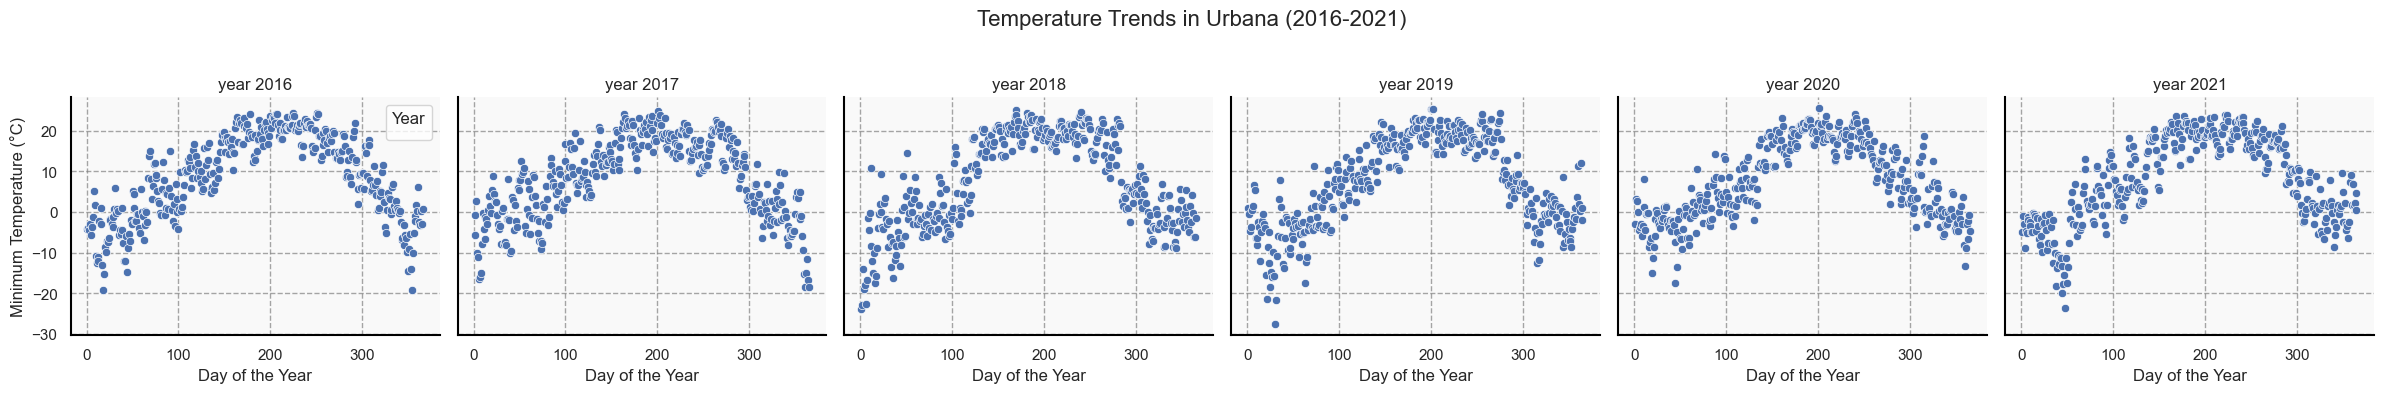

/var/folders/x_/71wrj7jx5474n6st5fwkvj7r0000gn/T/ipykernel_27736/3198050845.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=weather_train['year'], y=weather_train['temperature_2m_min'], palette=custom_palette)
/var/folders/x_/71wrj7jx5474n6st5fwkvj7r0000gn/T/ipykernel_27736/3198050845.py:47: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x=weather_train['year'], y=weather_train['temperature_2m_min'], palette=custom_palette)


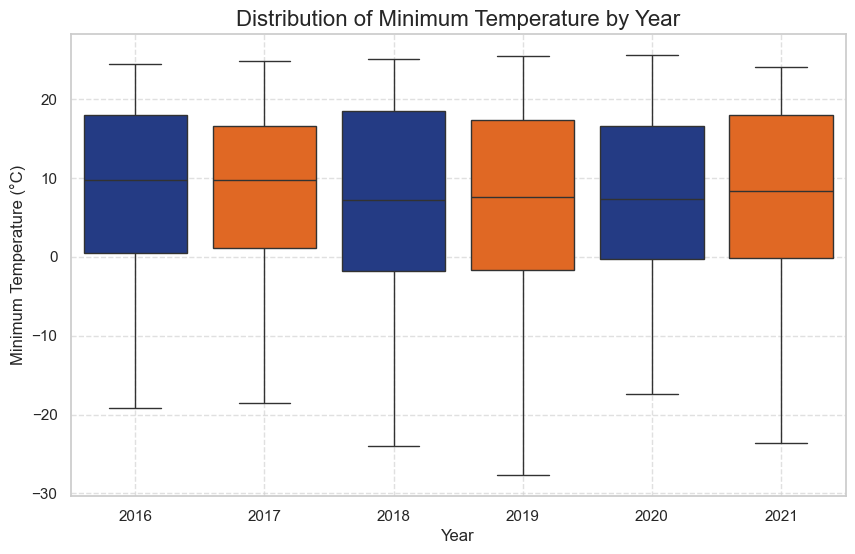

In [25]:
# visualizations

# Create a custom color palette
custom_palette =["#143294", "#FF5F05"]
sns.set_theme(style="whitegrid")

# Function to add jitter to x-values
def add_jitter(data, jitter_amount = 0.2):
    return data + np.random.uniform(-jitter_amount, jitter_amount,size = data.shape)

# Create a FacetGrid based on 'play_type' and 'converted' columns
g = sns.FacetGrid(weather_train,col = 'year',height = 4,aspect = 1,palette = custom_palette, legend_out = False)

# Map the scatterplot to each facet with jitter added to 'day_of_year'
g.map_dataframe(sns.scatterplot, x = add_jitter(weather_train['day_of_year']), y = "temperature_2m_min" )

# Add a legend for each subplot (Year)
g.add_legend(title = "Year")

# Modify axis labels and subplot titles
g.set_axis_labels('Day of the Year','Minimum Temperature (°C)')
g.set_titles(col_template = 'year {col_name}')

# Customize the grid's look and feel
for ax in g.axes.flat:
    ax.grid(True, which="both", linestyle="--", color="gray", alpha=0.7)
    # Light grey background
    ax.set_facecolor('#f9f9f9') 
    # Customize the spines
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Add an overall title to the entire plot
g.figure.suptitle("Temperature Trends in Urbana (2016-2021)", fontsize=16)

# Adjust the layout to make room for the title
g.figure.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

# Create another grid for comparison of the distributions by year using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x=weather_train['year'], y=weather_train['temperature_2m_min'], palette=custom_palette)
plt.title('Distribution of Minimum Temperature by Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Minimum Temperature (°C)')
plt.grid(True, which="both", linestyle="--", color="lightgrey", alpha=0.7)
plt.show()

### Models

In [13]:
# process data for ML

# create X and y for train
X_train = weather_train[["year", "day_of_year"]]
y_train = weather_train["temperature_2m_min"]

# create X and y for validation-train
X_vtrain = weather_vtrain[["year", "day_of_year"]]
y_vtrain = weather_vtrain["temperature_2m_min"]

# create X and y for validation
X_validation = weather_validation[["year", "day_of_year"]]
y_validation = weather_validation["temperature_2m_min"]

# create X and y for test
X_test = weather_test[["year", "day_of_year"]]
y_test = weather_test["temperature_2m_min"]

In [14]:
# import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

# import mean_squared_error
from sklearn.metrics import mean_squared_error



# train models
knn = KNeighborsRegressor(n_neighbors=200)

# fit the regression model to vtrain
knn.fit(X_vtrain, y_vtrain)

# deploy the model to make some predictions
pred_val = knn.predict(X_validation)

# calculate validation RMSE
rmse = np.sqrt(mean_squared_error(y_validation, pred_val))
rmse



np.float64(4.5850713556339056)

To compare different models' accuracy, we train a few more k-neighbors models with different k numbers

In [15]:
# train a model with k = 100
knn_100 = KNeighborsRegressor(n_neighbors=100)
knn_100.fit(X_vtrain, y_vtrain)
pred_val_100 = knn_100.predict(X_validation)
rmse_100 = np.sqrt(mean_squared_error(y_validation, pred_val_100))
print(rmse_100)


# train a model with k = 300
knn_300 = KNeighborsRegressor(n_neighbors=300)
knn_300.fit(X_vtrain, y_vtrain)
pred_val_300 = knn_300.predict(X_validation)
rmse_300 = np.sqrt(mean_squared_error(y_validation, pred_val_300))
print(rmse_300)

# train a model with k = 250
knn_250 = KNeighborsRegressor(n_neighbors=250)
knn_250.fit(X_vtrain, y_vtrain)
pred_val_250 = knn_250.predict(X_validation)
rmse_250 = np.sqrt(mean_squared_error(y_validation, pred_val_250))
print(rmse_250)



4.70645988033388
4.601686111675494
4.580698069854778


Based on the tests, a k-neighbor model with k = 250 is the more accurate model among the 4 models we tested. Therefore we decide to further test this model.

## Results

In [16]:
# test the model on completely unseen test data
pred_test_250 = knn_250.predict(X_test)

# calculate rmse on unseen test data
test_rmse = np.sqrt(mean_squared_error(y_test, pred_test_250))
test_rmse


np.float64(5.232809460870448)

In [17]:
# test Mean Absolute Error

# import mean absolute error from sklearn
from sklearn.metrics import mean_absolute_error

# calculate mean absolute error
mae = mean_absolute_error(y_validation, pred_val_250)
mae

np.float64(3.5521823845136704)

In [18]:
# test R-squared Score

# import R-squared Score from sklearn
from sklearn.metrics import r2_score


# calculate mean absolute error
r2 = r2_score(y_validation, pred_val_250)
r2

0.785346293314791

My predicted minimum temperatures, based on the RMSE, differs by 4.58°C compared to actual temperatures. Considering the actual temperature range is between about around 25°C to around -20°, I believe this level of RMSE is very small and would trust the accuracy of the model.

MAE of 3.55 means that, on average, the model’s predictions are off by about 3.55°C from the actual minimum temperatures, which is acceptable as a difference of a few °C won't cuase serious problems and don't affect whether people can sell and buy things outside of the mall. 

R² of 0.7853 means that the model explains about 78.5% of the variance in the variance of temperature.
This suggests that the model is performing reasonably well, though there’s still room for improvement.

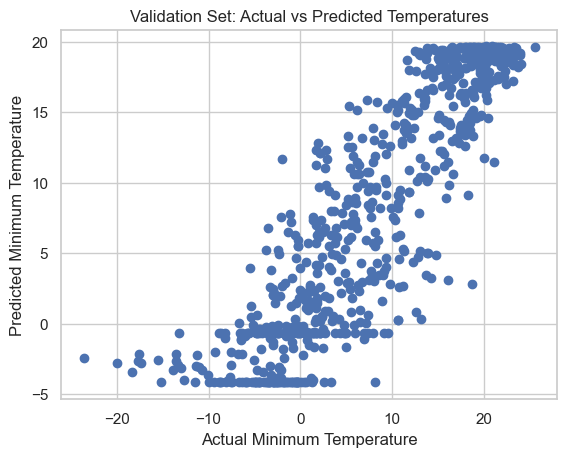

In [19]:
# visualizing the predicted vs actual values which help us to get a sense of the model’s accuracy

import matplotlib.pyplot as plt

plt.scatter(y_validation, pred_val_250)
plt.xlabel("Actual Minimum Temperature")
plt.ylabel("Predicted Minimum Temperature")
plt.title("Validation Set: Actual vs Predicted Temperatures")
plt.show()

In [20]:
# report model metrics
from joblib import dump
dump(knn, "urbana-weather.joblib")




['urbana-weather.joblib']

## Discussion

This lab was to develop a model that can predict the minimum daily temperature in Urbana to aid in deciding when the local farmer's market should move indoors. This was achieved using a KNN regression model. The model was designed to take year and day_of_year as inputs to predict the minimum temperature. Different performance metrics were used to evaluate the model’s predictions. Specifically, the RMSE was the main performance indicator, as it provides magnitude of the error in the model’s predictions. An RMSE of 4.58 was observed during validation, which implies that the model's predictions deviate by approximately 4.6°C from the actual values on average. Given that the dataset involves daily temperature predictions, this error seems reasonably low, though it could still be improved.

Additionally, the model’s MAE was calculated to be 3.552, which further confirms that, on average, the model's predictions are off by about 3.55°C. MAE is less sensitive to large errors than RMSE, and in this case, it suggests that the errors are relatively small. Furthermore, the R² score of 0.7853 was achieved. This means that approximately 78.5% of the variance in the minimum temperature is explained by the model. While this is a decent score, it leaves room for improvement.

One point of discussion is whether the KNN model is suitable for this type of time-series prediction. The choice of 250 neighbors (as set by the n_neighbors parameter) smooths out fluctuations in temperature over time, but there may be a more suitable model for time-based prediction.



### Conclusion

The K-Nearest Neighbors model used in this lab demonstrated reasonable predictive power, achieving an RMSE of 4.585 and an R2 score of 0.7853. The model was able to explain a significant portion of the variance in minimum daily temperaures based on the features year and day_of_year. However, given the scale of prediction errors (around 4.6°C), this model may need improvement before being deployed in a real-world scenario where accurate predictions of temperature are critical for making business decisions, such as moving a farmer's market indoors.